# Filtering

Given that (in current designs) there is no filtering to the input of the 1-bit ADC/SERDES, we need to filter out unwatned frequencies in hardware. There are zillions of ways to design filters, but for the moment we only use stupidly simple ones

In [4]:
%matplotlib inline
import numpy as np
from numpy.fft import fft, fftfreq
import matplotlib.pyplot as plt

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from alldigitalradio.filter import RunningBoxcarFilter, SimpleDecimator
from alldigitalradio.io.numpy import make_callable, take_n
from alldigitalradio.util import make_carrier

# Boxcar Filter

The first filter we need is a low-pass filter to smooth out the quantization we see at every 1-bit sample.

One of the simpler (conceptual) ways to do this is to compute a running average.

There are a lot of smart ways to do this, but I chose a dumb one: 
    
1. Keep a queue of samples in BRAM
2. Add new samples to the running sum and push them onto the queue
3. Pop samples off the back of the queue and subtract them

I think the smart way to do this is a CIC filter, which I'll write eventually (it's not complicated). But for now, let's demonstrate this "boxcar" filter named as such because it's just a convolution with all coefficients of 1 (which I guess looks like a boxcar). Also notably, there's no division so there is a bunch of "gain" in the resulting values.

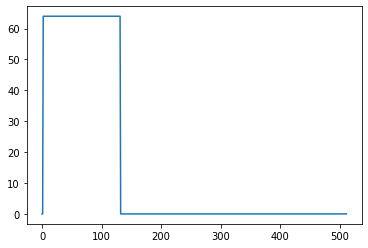

In [2]:
impulse = np.zeros((512,),dtype=np.uint8)
impulse[1] = 64

filt = RunningBoxcarFilter(128)
filt = make_callable(filt, inputs=[filt.input], outputs=[filt.output])

filtered = np.array(list(map(filt, map(int, impulse))))
plt.plot(filtered)

This is... not a particularly surprising looking graph, but let's still run an FFT to approximate the frequency response.

<ipython-input-3-aa422b424fd3>:9: RuntimeWarning: divide by zero encountered in log10
  plt.plot(fftfreq(len(filtered)), 10*np.log10(f))


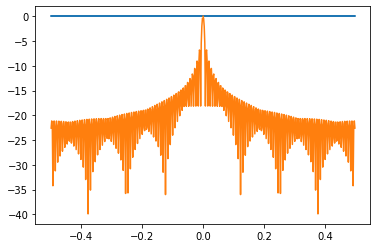

<ipython-input-3-aa422b424fd3>:14: RuntimeWarning: divide by zero encountered in log10
  plt.plot(fftfreq(len(filtered)), 10*np.log10(f))


(0.0, 0.02)

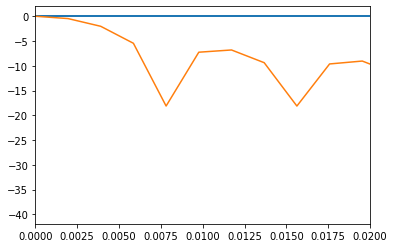

In [3]:
i = np.abs(fft(impulse))
i = i/np.max(i)

f = np.abs(fft(filtered))
f = f/np.max(f)

# First plot the frequency response for a full normalized requency
plt.plot(fftfreq(len(i)), 10*np.log10(i))
plt.plot(fftfreq(len(filtered)), 10*np.log10(f))
plt.show()

# Now zoom in to look at the approximate 3db point
plt.plot(fftfreq(len(i)), 10*np.log10(i))
plt.plot(fftfreq(len(filtered)), 10*np.log10(f))
plt.gca().set_xlim(0, 0.02)

This plot is against normalized frequency, so for a 5gsps signal, the cutoff point is something like `0.004*5ghz = 20mhz` 

# Simple "Decimator"

This is probably a useless module in the grand scheme of things, it just sums up every N samples.

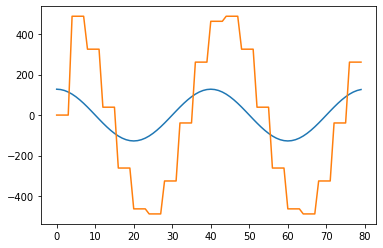

In [14]:
signal = make_carrier(freq=1, sample_rate=40, samples=80)*128
plt.plot(signal)

dec = SimpleDecimator(decimation_factor=4)
dec = make_callable(dec, inputs=[dec.input], outputs=[dec.output])
plt.plot(list(map(dec, map(int, signal))))